In [1]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import librosa
from tqdm import tqdm
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, LSTM, Dense, Dropout, Flatten, Reshape, BatchNormalization, Layer
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping, LearningRateScheduler
from sklearn.preprocessing import StandardScaler
from sklearn.utils import class_weight
import librosa.effects
from tensorflow.keras.layers import MultiHeadAttention, LayerNormalization
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.utils import to_categorical
import pickle
import warnings
warnings.filterwarnings('ignore')


videodemo = "/kaggle/input/audio-meta-files/VideoDemographics.csv"
aud = "/kaggle/input/cremad/AudioWAV"
emotion_dict = {'ANG': 0, 'DIS': 1, 'FEA': 2, 'HAP': 3, 'SAD': 4, 'NEU': 5}
metaf = pd.read_csv(videodemo, usecols=['ActorID'])
EPOCHS = 75

2025-08-07 04:58:27.731535: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1754542708.098737      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1754542708.203169      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
#Wrapper layer for MultiHeadAttention
class MultiHeadAttentionWrapper(Layer):
    def __init__(self, num_heads, key_dim, **kwargs):
        super(MultiHeadAttentionWrapper, self).__init__(**kwargs)
        self.num_heads = num_heads
        self.key_dim = key_dim
        self.attention = MultiHeadAttention(num_heads=num_heads, key_dim=key_dim)

    def call(self, inputs):
        return self.attention(inputs, inputs) 

    def compute_output_shape(self, input_shape):
        return input_shape

In [3]:
def lr_schedule(epoch):
    initial_lr = 0.0002
    if epoch < 30:
        return initial_lr
    else:
        return initial_lr * (0.5 ** ((epoch - 30) // 10))


def add_tremble(y, sr, intensity=0.02): #For sadness
    t = np.arange(len(y)) / sr
    tremble = intensity * np.sin(2 * np.pi * 10 * t)  #10 Hz tremble
    return y * (1 + tremble)

In [4]:
def extract_features(file_path, n_mfcc=13, max_length=100, augment=False, emotion=None):
    y, sr = librosa.load(file_path, sr=22050)
    
    if augment:
        if np.random.random() > 0.5:
            y = librosa.effects.pitch_shift(y, sr=sr, n_steps=np.random.uniform(-2, 2))
        if np.random.random() > 0.5:
            y = librosa.effects.time_stretch(y, rate=np.random.uniform(0.8, 1.2))
        if np.random.random() > 0.5:
            noise = np.random.normal(0, 0.001, y.shape)
            y = y + noise
        if emotion == 'DIS' and np.random.random() > 0.5:
            y = librosa.effects.pitch_shift(y, sr=sr, n_steps=np.random.uniform(-1, 1))
        if emotion == 'SAD' and np.random.random() > 0.5:
            y = librosa.effects.time_stretch(y, rate=np.random.uniform(0.7, 0.9))
            y = add_tremble(y, sr, intensity=0.02)
    
    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc)
    delta_mfcc = librosa.feature.delta(mfcc)
    
    pitches, magnitudes = librosa.piptrack(y=y, sr=sr)
    pitch = pitches[magnitudes > 0].mean() if magnitudes.sum() > 0 else 0
    pitch = np.full((1, mfcc.shape[1]), pitch)
    
    energy = librosa.feature.rms(y=y)
    zcr = librosa.feature.zero_crossing_rate(y)
    
    spectral_contrast = librosa.feature.spectral_contrast(y=y, sr=sr, n_bands=4)
    
    features = [mfcc, delta_mfcc, energy, zcr, pitch, spectral_contrast]
    for i, feature in enumerate(features):
        if feature.shape[1] < max_length:
            pad_width = max_length - feature.shape[1]
            features[i] = np.pad(feature, ((0, 0), (0, pad_width)), mode='constant')
        else:
            features[i] = feature[:, :max_length]
        expected_shape = (feature.shape[0], max_length)
        if features[i].shape != expected_shape:
            raise ValueError(f"Feature shape mismatch: expected {expected_shape}, got {features[i].shape}")
    
    stacked_features = np.vstack(features)
    if stacked_features.shape != (n_mfcc + n_mfcc + 3 + 5, max_length):
        raise ValueError(f"Stacked features shape mismatch: expected {(n_mfcc + n_mfcc + 3 + 5, max_length)}, got {stacked_features.shape}")
    
    return stacked_features

In [5]:
#Augmentation
def load_data(audio_dir, emotion_dict):
    X, y = [], []
    for file in tqdm(os.listdir(audio_dir)):
        if file.endswith('.wav'):
            emotion = file.split('_')[2]
            if emotion in emotion_dict:
                file_path = os.path.join(audio_dir, file)
                features = extract_features(file_path, augment=False, emotion=emotion)
                X.append(features)
                y.append(emotion_dict[emotion])
                features_aug = extract_features(file_path, augment=True, emotion=emotion)
                X.append(features_aug)
                y.append(emotion_dict[emotion])
    return np.array(X), np.array(y)

In [6]:
#LSTM-CNN model
def build_model(input_shape, num_classes):
    model = Sequential([
        Conv2D(64, (3, 3), activation='relu', padding='same', input_shape=input_shape, kernel_regularizer=tf.keras.regularizers.l2(0.007)),
        BatchNormalization(),
        MaxPooling2D((2, 2)),
        Dropout(0.375),
        Conv2D(128, (3, 3), activation='relu', padding='same', kernel_regularizer=tf.keras.regularizers.l2(0.007)),
        BatchNormalization(),
        MaxPooling2D((2, 2)),
        Dropout(0.375),
        Conv2D(256, (3, 3), activation='relu', padding='same', kernel_regularizer=tf.keras.regularizers.l2(0.007)),
        BatchNormalization(),
        MaxPooling2D((2, 2)),
        Dropout(0.375),
        
        Reshape((-1, 256 * (input_shape[0] // 8) * (input_shape[1] // 8))),
        
        LSTM(256, return_sequences=True, dropout=0.375, recurrent_dropout=0.375),
        LSTM(128, return_sequences=True, dropout=0.375, recurrent_dropout=0.375),
        
        Reshape((-1, 128)),
        MultiHeadAttentionWrapper(num_heads=2, key_dim=64),
        LayerNormalization(),
        Flatten(),
        
        Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.007)),
        Dropout(0.575),
        Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.007)),
        Dropout(0.575),
        Dense(num_classes, activation='softmax')
    ])
    
    model.compile(optimizer=Adam(learning_rate=0.0002),
                  loss=CategoricalCrossentropy(label_smoothing=0.1),
                  metrics=['accuracy'])
    model.summary()
    return model

100%|██████████| 7442/7442 [11:38<00:00, 10.65it/s]
I0000 00:00:1754543446.040789      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1754543446.041374      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 34, 100, 64)    │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 34, 100, 64)    │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 17, 50, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 17, 50, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 17, 50, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 17, 50, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 8, 25, 128)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 8, 25, 128)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 8, 25, 256)     │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 8, 25, 256)     │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 4, 12, 256)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 4, 12, 256)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 1, 12288)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 1, 256)         │    12,846,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 1, 128)         │       197,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_1 (Reshape)             │ (None, 1, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ multi_head_attention_wrapper    │ (None, 1, 128)         │        66,048 │
│ (MultiHeadAttentionWrapper)     │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer_normalization             │ (None, 1, 128)         │           256 │
│ (LayerNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 13,547,654 (51.68 MB)

 Trainable params: 13,546,758 (51.68 MB)

 Non-trainable params: 896 (3.50 KB)

Epoch 1/75


E0000 00:00:1754543462.805389      36 meta_optimizer.cc:966] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inStatefulPartitionedCall/sequential_1/dropout_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
I0000 00:00:1754543464.049002     110 cuda_dnn.cc:529] Loaded cuDNN version 90300


149/149 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - accuracy: 0.1879 - loss: 5.9303
Epoch 1: val_accuracy improved from -inf to 0.16793, saving model to /kaggle/working/emotiontask3.weights.h5
149/149 ━━━━━━━━━━━━━━━━━━━━ 32s 79ms/step - accuracy: 0.1881 - loss: 5.9285 - val_accuracy: 0.1679 - val_loss: 5.1554 - learning_rate: 2.0000e-04
Epoch 2/75
148/149 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - accuracy: 0.3112 - loss: 4.9250
Epoch 2: val_accuracy did not improve from 0.16793
149/149 ━━━━━━━━━━━━━━━━━━━━ 9s 58ms/step - accuracy: 0.3113 - loss: 4.9223 - val_accuracy: 0.1385 - val_loss: 4.4894 - learning_rate: 2.0000e-04
Epoch 3/75
148/149 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - accuracy: 0.3500 - loss: 4.1842
Epoch 3: val_accuracy improved from 0.16793 to 0.21914, saving model to /kaggle/working/emotiontask3.weights.h5
149/149 ━━━━━━━━━━━━━━━━━━━━ 9s 63ms/step - accuracy: 0.3502 - loss: 4.1820 - val_accuracy: 0.2191 - val_loss: 3.7839 - learning_rate: 2.0000e-04
Epoch 4/75
148/149 ━━━━━━━━━━━━━━━━━━━━

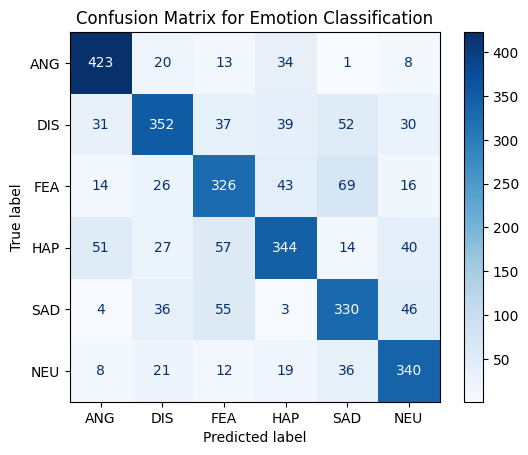

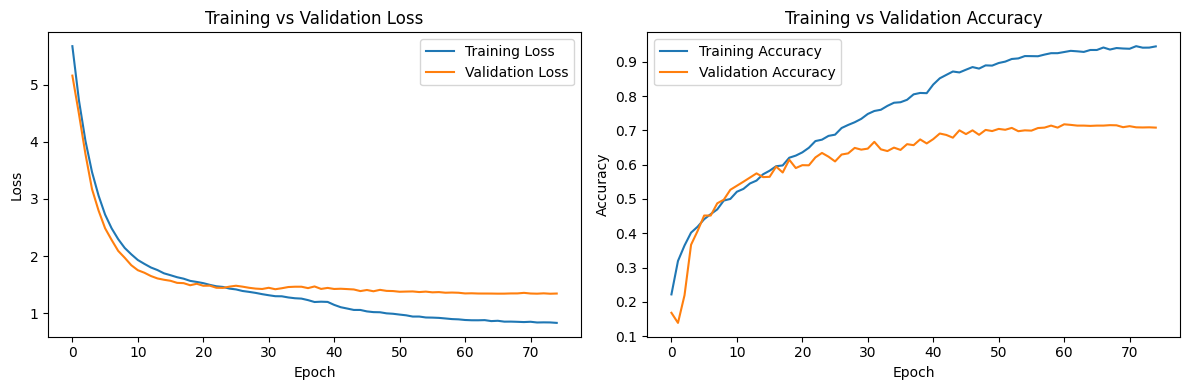

In [7]:
X, y = load_data(aud, emotion_dict)
X = X[..., np.newaxis]

#Normalization
scaler = StandardScaler()
X_reshaped = X.reshape(-1, X.shape[1] * X.shape[2] * X.shape[3])
X_normalized = scaler.fit_transform(X_reshaped)
with open('/kaggle/working/emotion_scaler.pkl', 'wb') as f:
    pickle.dump(scaler, f)
X = X_normalized.reshape(X.shape)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

#One-hot encoding
y_train = to_categorical(y_train, num_classes=len(emotion_dict))
y_val = to_categorical(y_val, num_classes=len(emotion_dict))
y_test = to_categorical(y_test, num_classes=len(emotion_dict))

class_weights = class_weight.compute_class_weight('balanced', classes=np.unique(np.argmax(y_train, axis=1)), y=np.argmax(y_train, axis=1))
class_weights_dict = dict(enumerate(class_weights))
class_weights_dict[1] *= 1.2  #Increasing class weight for DIS
class_weights_dict[4] *= 1.2  #Increasing class weight for SAD

input_shape = (X_train.shape[1], X_train.shape[2], X_train.shape[3])  
num_classes = len(emotion_dict)
model = build_model(input_shape, num_classes)

checkpoint = ModelCheckpoint(
    "/kaggle/working/emotiontask3.weights.h5", 
    monitor='val_accuracy', 
    save_best_only=True, 
    save_weights_only=True, 
    mode='max', 
    verbose=1
)
early_stopping = EarlyStopping(
    monitor='val_accuracy', 
    patience=15, 
    restore_best_weights=True, 
    verbose=1
)
lr_scheduler = ReduceLROnPlateau(
    monitor='val_loss', 
    factor=0.5, 
    patience=5, 
    min_lr=1e-6, 
    verbose=1
)
lr_callback = LearningRateScheduler(lr_schedule)

history = model.fit(
    X_train, 
    y_train,
    validation_data=(X_val, y_val),
    epochs=75,
    batch_size=64,
    class_weight=class_weights_dict,
    callbacks=[checkpoint, lr_scheduler, early_stopping, lr_callback],
    verbose=1
)
print("Loading best weights")
model.load_weights("/kaggle/working/emotiontask3.weights.h5")

test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"\nTest Accuracy: {test_accuracy:.4f}")
print(f"Test Loss: {test_loss:.4f}")
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_test_classes = np.argmax(y_test, axis=1)
cm = confusion_matrix(y_test_classes, y_pred_classes)

precision = precision_score(y_test_classes, y_pred_classes, average='weighted')
recall = recall_score(y_test_classes, y_pred_classes, average='weighted')
f1 = f1_score(y_test_classes, y_pred_classes, average='weighted')
print(f"Test Precision: {precision:.4f}")
print(f"Test Recall: {recall:.4f}")
print(f"Test F1 Score: {f1:.4f}")

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=list(emotion_dict.keys()))
disp.plot(cmap='Blues')
plt.title('Confusion Matrix for Emotion Classification')
plt.show()

model.save('/kaggle/working/emotiontask3.h5')

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training vs Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training vs Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()